In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [97]:
import os.path 
dir = '/content/drive/My Drive/data'
isdir = os.path.isdir(dir)  
print(isdir)
print(os.getcwd())

True
/content


In [98]:
data_dir = '/content/drive/My Drive/datac'

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(64),
                                       transforms.ToTensor(),
                                       ])    
    test_transforms = transforms.Compose([transforms.Resize(64),
                                      transforms.ToTensor(),
                                      ])    
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['Live', 'Review']


In [99]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [100]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(512,128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(128, 10),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(10, 2),
                                 nn.Softmax(dim=1))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [101]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_m = [], [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))   
            accuracy_m.append(accuracy/len(testloader))                  
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, '/content/drive/My Drive/cricket-model-4.pth')

Epoch 1/10.. Train loss: 0.885.. Validation loss: 0.327.. Test accuracy: 0.900
Epoch 1/10.. Train loss: 0.341.. Validation loss: 0.176.. Test accuracy: 0.957
Epoch 1/10.. Train loss: 0.222.. Validation loss: 0.134.. Test accuracy: 0.972
Epoch 1/10.. Train loss: 0.143.. Validation loss: 0.093.. Test accuracy: 0.977
Epoch 1/10.. Train loss: 0.115.. Validation loss: 0.084.. Test accuracy: 0.977
Epoch 1/10.. Train loss: 0.115.. Validation loss: 0.082.. Test accuracy: 0.978
Epoch 1/10.. Train loss: 0.122.. Validation loss: 0.103.. Test accuracy: 0.972
Epoch 1/10.. Train loss: 0.193.. Validation loss: 0.068.. Test accuracy: 0.981
Epoch 2/10.. Train loss: 0.150.. Validation loss: 0.104.. Test accuracy: 0.966
Epoch 2/10.. Train loss: 0.073.. Validation loss: 0.058.. Test accuracy: 0.984
Epoch 2/10.. Train loss: 0.062.. Validation loss: 0.087.. Test accuracy: 0.973
Epoch 2/10.. Train loss: 0.101.. Validation loss: 0.063.. Test accuracy: 0.978
Epoch 2/10.. Train loss: 0.078.. Validation loss: 0.

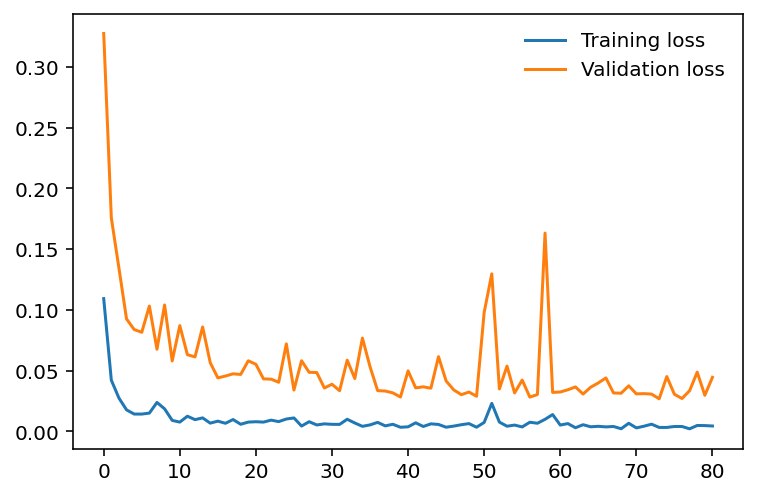

In [102]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

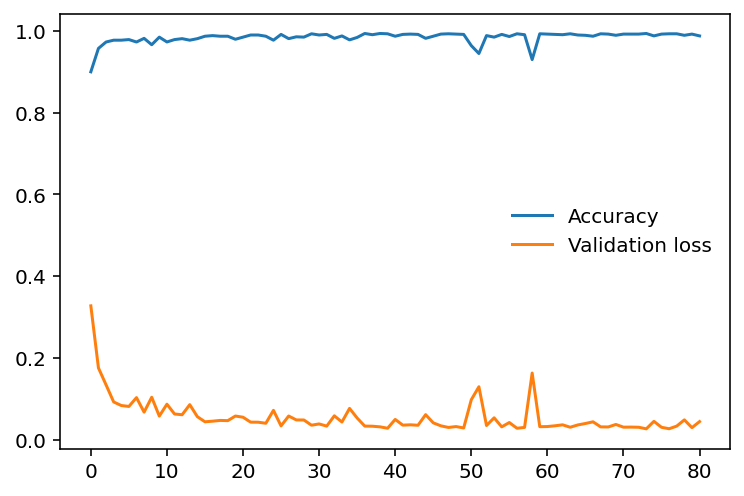

In [103]:
plt.plot(accuracy_m, label='Accuracy')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()